CHALLENGE: Working with the King County House Sales dataset, build a multivariate linear regression model to predict the sale price of houses as accurately as possible.

RESULT: Produced an multivariate OLS model with consistent 87% predictive accuracy (Adjusted R-squared of 0.87). 

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In an earlier model I dropped 'waterfront', 'yr_renovated', and 'view'; partly to deal with the zero-heavy data and partly to handle the missing values. For this model, I decided to keep the variables, change the NaNs to zeros and to change 'yr_renovated' to a simple one-zero binary variable, which basically captures whether a house has ever been renovated or not.

In [69]:
df['waterfront'] = df['waterfront'].fillna(0)
df['waterfront'].isna().sum()

df['yr_renovated'] = df['yr_renovated'].fillna(0)
df.loc[df['yr_renovated'] != 0, 'yr_renovated'] = 1

df['view'] = df['view'].fillna(0)

In [26]:
df['waterfront'].value_counts()

0.0    21451
1.0      146
Name: waterfront, dtype: int64

In [27]:
df['yr_renovated'].value_counts()

0.0    20853
1.0      744
Name: yr_renovated, dtype: int64

In [28]:
df['view'].value_counts()

0.0    19485
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

I decided to leverage 'zipcode' for location purposes; and hence, dropped 'lat' and 'long'.

I dropped 'id' because it wasn't meaningful for this purposes.

I dropped 'date' because I didn't think it entailed enough variety (all dates fell between 2014 & 2015). Said another way, to my mind, it didn't contribute enough meaningfully diverse values to the model.

In [70]:
df = df.drop(columns=['lat', 'long', 'id', 'date'], axis=1)

Addressed presence of '?' in 'sqft_basement'; changed the datatype.

In [71]:
df['sqft_basement'] = df['sqft_basement'].replace(to_replace='?', value='0').astype(str).astype(float).astype(int)

In 'Final Version' model dropped 'sqft_basement' because it was a zero-inflated variable, which would be challenging to work with for very little reward. Here, I decided to turn it into a dummy variable.

In [72]:
#df = df.drop(columns=['sqft_basement'], axis=1)
df.loc[df['sqft_basement'] != 0, 'sqft_basement'] = 1
df['sqft_basement'].value_counts()

0    13280
1     8317
Name: sqft_basement, dtype: int64

Dropped 1.3% of data (284 observations out of 21,597). A number of a outliers and top-end influencers that were impacting different independent variables.

In [73]:
indexNames = df[df['sqft_living'] >= 5000].index
df.drop(indexNames, inplace=True)

indexNames2 = df[df['bedrooms'] >= 8].index
df.drop(indexNames2, inplace=True)

indexNames3 = df[df['sqft_lot'] > 400000].index
df.drop(indexNames3, inplace=True)

indexNames4 = df[df['floors'] > 3.0].index
df.drop(indexNames4, inplace=True)

df.shape

(21313, 17)

In [11]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
price,1.000000,0.301720,0.487058,0.658674,0.076871,0.258218,0.228351,0.381349,0.050724,0.659101,0.558058,0.171019,0.040137,0.123276,-0.039223,0.584406,0.060409
bedrooms,0.301720,1.000000,0.514510,0.601117,0.041104,0.174992,-0.012270,0.063998,0.027958,0.353452,0.488243,0.148300,0.165418,0.015052,-0.158621,0.397135,0.028090
bathrooms,0.487058,0.514510,1.000000,0.736515,0.071604,0.506416,0.042462,0.155886,-0.124833,0.643659,0.659386,0.148325,0.519344,0.045565,-0.202622,0.551037,0.060859
sqft_living,0.658674,0.601117,0.736515,1.000000,0.180898,0.355343,0.068717,0.243786,-0.055257,0.745780,0.860724,0.190491,0.329830,0.050592,-0.200616,0.756137,0.161346
sqft_lot,0.076871,0.041104,0.071604,0.180898,1.000000,-0.027852,0.024228,0.055470,-0.013527,0.115013,0.189498,-0.041103,0.061600,0.009105,-0.151817,0.182307,0.788186
floors,0.258218,0.174992,0.506416,0.355343,-0.027852,1.000000,0.014193,0.015799,-0.264831,0.457006,0.534995,-0.262095,0.491718,0.003607,-0.058485,0.272903,-0.027392
waterfront,0.228351,-0.012270,0.042462,0.068717,0.024228,0.014193,1.000000,0.372157,0.018975,0.059467,0.043140,0.031387,-0.029486,0.072904,0.031220,0.067880,0.035129
view,0.381349,0.063998,0.155886,0.243786,0.055470,0.015799,0.372157,1.000000,0.048905,0.219858,0.124872,0.169298,-0.066477,0.092743,0.095444,0.257105,0.052479
condition,0.050724,0.027958,-0.124833,-0.055257,-0.013527,-0.264831,0.018975,0.048905,1.000000,-0.146036,-0.162403,0.132471,-0.360061,-0.055690,0.000384,-0.091536,-0.000425
grade,0.659101,0.353452,0.643659,0.745780,0.115013,0.457006,0.059467,0.219858,-0.146036,1.000000,0.736899,0.033751,0.452003,0.014454,-0.180836,0.699930,0.098835


Dropped 'sqft_above' and 'sqft_living15' for colinearity with 'sqft_living' [used a .75 threshhold].

In [74]:
df_dropped = df.drop(columns=['sqft_above', 'sqft_living15'], axis=1)

In [13]:
df_dropped.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,sqft_lot15
price,1.000000,0.301720,0.487058,0.658674,0.076871,0.258218,0.228351,0.381349,0.050724,0.659101,0.171019,0.040137,0.123276,-0.039223,0.060409
bedrooms,0.301720,1.000000,0.514510,0.601117,0.041104,0.174992,-0.012270,0.063998,0.027958,0.353452,0.148300,0.165418,0.015052,-0.158621,0.028090
bathrooms,0.487058,0.514510,1.000000,0.736515,0.071604,0.506416,0.042462,0.155886,-0.124833,0.643659,0.148325,0.519344,0.045565,-0.202622,0.060859
sqft_living,0.658674,0.601117,0.736515,1.000000,0.180898,0.355343,0.068717,0.243786,-0.055257,0.745780,0.190491,0.329830,0.050592,-0.200616,0.161346
sqft_lot,0.076871,0.041104,0.071604,0.180898,1.000000,-0.027852,0.024228,0.055470,-0.013527,0.115013,-0.041103,0.061600,0.009105,-0.151817,0.788186
floors,0.258218,0.174992,0.506416,0.355343,-0.027852,1.000000,0.014193,0.015799,-0.264831,0.457006,-0.262095,0.491718,0.003607,-0.058485,-0.027392
waterfront,0.228351,-0.012270,0.042462,0.068717,0.024228,0.014193,1.000000,0.372157,0.018975,0.059467,0.031387,-0.029486,0.072904,0.031220,0.035129
view,0.381349,0.063998,0.155886,0.243786,0.055470,0.015799,0.372157,1.000000,0.048905,0.219858,0.169298,-0.066477,0.092743,0.095444,0.052479
condition,0.050724,0.027958,-0.124833,-0.055257,-0.013527,-0.264831,0.018975,0.048905,1.000000,-0.146036,0.132471,-0.360061,-0.055690,0.000384,-0.000425
grade,0.659101,0.353452,0.643659,0.745780,0.115013,0.457006,0.059467,0.219858,-0.146036,1.000000,0.033751,0.452003,0.014454,-0.180836,0.098835


Dropped 'sqft_lot15' because of colinearity concerns with 'sqft_lot'.

In [75]:
df_dropped.drop(columns=['sqft_lot15'], axis=1, inplace=True)

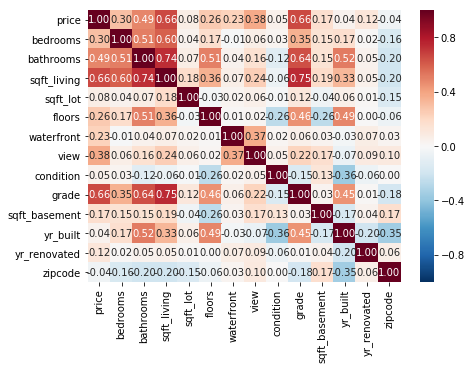

In [76]:
import seaborn as sns
#sns.heatmap(df_dropped.corr(), center=0);
correlation = df_dropped.corr()
plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(correlation, annot=True, fmt = '.2f', linewidths=0, vmin=-1, cmap="RdBu_r")

In [77]:
df_dropped.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,0,1955,0.0,98178
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,1,1951,1.0,98125
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,0,1933,0.0,98028
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1,1965,0.0,98136
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,0,1987,0.0,98074


Converted three columns that have zero-one values from floats to integers (for memory purposes).

In [79]:
df_dropped['view'] = df_dropped['view'].astype(int)
df_dropped['waterfront'] = df_dropped['waterfront'].astype(int)
df_dropped['yr_renovated'] = df_dropped['yr_renovated'].astype(int)

In [53]:
#decade = ["{0}".format(year, year + 10) for year in range(1900, 2030, 10)]
#count_unique_decade = len(decade)

#df_dropped['decade_built'] = pd.cut(x=df_dropped['yr_built'], bins=count_unique_decade, labels=decade)
#df_dropped.drop(columns=['yr_built'], axis=1, inplace=True)

Created dummy variables for 'yr_built', 'condition', and 'zipcode'.

In [81]:
#grade_dummies = pd.get_dummies(df_dropped['grade'], prefix="gd")
zip_dummies = pd.get_dummies(df_dropped['zipcode'], prefix="zp")
#decade_dummies = pd.get_dummies(df_dropped['decade_built'], prefix="dec")
year_dummies = pd.get_dummies(df_dropped['yr_built'], prefix="yr")
condition_dummies = pd.get_dummies(df_dropped['condition'], prefix="cond")
#floors_dummies = pd.get_dummies(df_dropped['floors'], prefix="floor")
#view_dummies = pd.get_dummies(df_dropped['view'], prefix="view")

df_dropped = df_dropped.drop(['zipcode', 'yr_built', 'condition'], axis=1)

df_dropped = pd.concat([df_dropped, zip_dummies, year_dummies, condition_dummies], axis=1)
df_dropped.head(2)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_basement,...,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015,cond_1,cond_2,cond_3,cond_4,cond_5
0,221900.0,3,1.00,1180,5650,1.0,0,0,7,0,...,0,0,0,0,0,0,0,1,0,0
1,538000.0,3,2.25,2570,7242,2.0,0,0,7,1,...,0,0,0,0,0,0,0,1,0,0


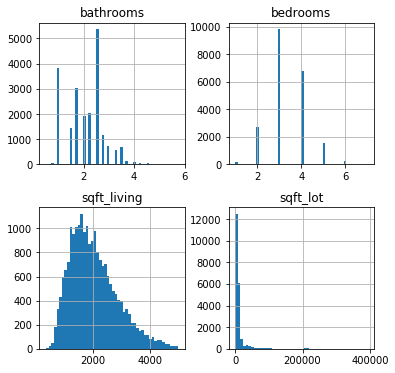

In [82]:
import matplotlib.pyplot as plt

%matplotlib inline

df_dropped[["sqft_living", "sqft_lot", "bedrooms", "bathrooms"]].hist(bins=50, figsize  = [6, 6])
plt.show()

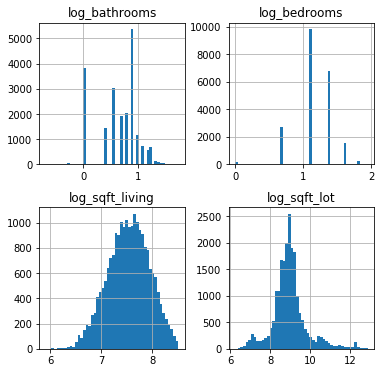

In [83]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

data_log = pd.DataFrame([])
data_log["log_sqft_living"] = np.log(df_dropped["sqft_living"])
data_log["log_sqft_lot"] = np.log(df_dropped["sqft_lot"])
#data_log["log_floors"] = np.log(df_dropped['floors'])
data_log["log_bedrooms"] = np.log(df_dropped["bedrooms"])
data_log["log_bathrooms"] = np.log(df_dropped["bathrooms"])
data_log.hist(bins=50, figsize  = [6, 6]);

Transformed 'sqft_living', 'sqft_lot', 'bedrooms' & 'bathrooms' to bring these features more in line with the assumptions of the normal distribution. Also, standardized these features using mean normalization.

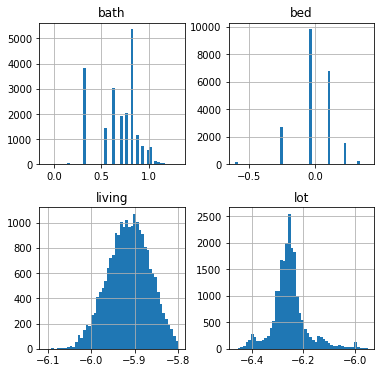

In [84]:
logbath = data_log["log_bathrooms"]
logbed = data_log["log_bedrooms"]
logsqftliving = data_log["log_sqft_living"]
logsqftlot = data_log["log_sqft_lot"]
#logfloors = data_log["log_floors"]

#Standardized using median & .75-.25 quartile normalization
#scaled_bed = (logbed-np.median(logbed))/(logbed.quantile(.75))-(logbed.quantile(.25))
#scaled_sqft_living = (logsqftliving-np.median(logsqftliving))/(logsqftliving.quantile(.75))-(logsqftliving.quantile(.25))
#scaled_sqft_lot = (logsqftlot-np.median(logsqftlot))/(logsqftlot.quantile(.75))-(logsqftlot.quantile(.25))

#Standardized using mean normalization
scaled_bed = (logbed-np.mean(logbed))/(max(logbed))-(min(logbed))
scaled_bath = (logbath-np.mean(logbath))/(max(logbath))-(min(logbath))
scaled_sqft_living = (logsqftliving-np.mean(logsqftliving))/(max(logsqftliving))-(min(logsqftliving))
scaled_sqft_lot = (logsqftlot-np.mean(logsqftlot))/(max(logsqftlot))-(min(logsqftlot))
#scaled_floors = (logfloors-np.mean(logfloors))/(max(logfloors)-min(logfloors))

data_cont_scaled = pd.DataFrame([])
data_cont_scaled["bath"]= scaled_bath
data_cont_scaled["bed"]= scaled_bed
data_cont_scaled["living"]= scaled_sqft_living
data_cont_scaled["lot"] = scaled_sqft_lot
#data_cont_scaled["floors"] = scaled_floors

data_cont_scaled.hist(bins=50, figsize  = [6, 6]);

In [85]:
df_dropped['bedrooms'] = data_cont_scaled["bed"]
df_dropped['bathrooms'] = data_cont_scaled["bath"]
df_dropped['sqft_living'] = data_cont_scaled["living"]
df_dropped['sqft_lot'] = data_cont_scaled["lot"]
#df_dropped['floors'] = data_cont_scaled["floors"]

Changed our outcome variable from 'price' to 'log_price'. The distribution of 'log_price' better fits that of a normal distribution than the right-skewed distribution of 'price'.

In [86]:
df_dropped['log_price'] = np.log(df_dropped['price'])
df_dropped.drop(columns=['price'], axis=1, inplace=True)
df_dropped.head(3)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_basement,yr_renovated,...,yr_2012,yr_2013,yr_2014,yr_2015,cond_1,cond_2,cond_3,cond_4,cond_5,log_price
0,-0.038467,0.310558,-5.968133,-6.279494,1.0,0,0,7,0,0,...,0,0,0,0,0,0,1,0,0,12.309982
1,-0.038467,0.774159,-5.876699,-6.260221,2.0,0,0,7,1,1,...,0,0,0,0,0,0,1,0,0,13.195614
2,-0.246835,0.310558,-6.018276,-6.235168,1.0,0,0,6,0,0,...,0,0,0,0,0,0,1,0,0,12.100712


In [261]:
#import pandas as pd
#from sklearn import preprocessing

#float_array = df_dropped['sqft_living'].values.astype(float)
#min_max_scaler = preprocessing.MinMaxScaler()
#np_scaled = min_max_scaler.fit_transform(float_array)
#df_normalized = pd.DataFrame(np_scaled)
#df_normalized.head()

With our ols model completed, we're ready to import the necessary libraries and run the model.

In [88]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np

In [11]:
#formula = "price ~ sqft_living+floors+bedrooms+sqft_living15"
#model = ols(formula= formula, data=df_dropped).fit()

In [89]:
outcome = 'log_price'
predictors = df_dropped.drop('log_price', axis=1)

pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum

In [90]:
model = ols(formula= formula, data=df_dropped).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     768.2
Date:                Tue, 25 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:43:02   Log-Likelihood:                 6608.8
No. Observations:               21313   AIC:                        -1.282e+04
Df Residuals:                   21114   BIC:                        -1.123e+04
Df Model:                         198                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        33.1057      0.289    114.583      0.000      32.539      33.672
bedrooms         -0.0561      0.012     -4.647      0.000      -0.080      -0.032
bathrooms         0.0907      0.010      8.689      0.000       0.070       0.111
sqft_living       3.7342      0.059     63.360      0.000       3.619       3.850
sqft_lot          1.0019      0.029     34.658      0.000       0.945       1.059
floors           -0.0295      0.004     -7.720      0.000      -0.037      -0.022
waterfront        0.4531      0.018     25.853      0.000       0.419       0.487
view              0.0723      0.002     37.103      0.000       0.069       0.076
grade             0.1068      0.002     54.815      0.000       0.103       0.111
sqft_basement    -0.0336      0.003    -10.073      0.000      -0.040      -0.027
yr_renovated      0.0549      0.007      7.556      0.000       0.041       0.069
zp_98001         -0.0168      0.010     -1.652      0.099      -0.037       0.003
zp_98002         -0.0270      0.013     -2.027      0.043      -0.053      -0.001
zp_98003          0.0250      0.012      2.173      0.030       0.002       0.048
zp_98004          1.1429      0.011    100.906      0.000       1.121       1.165
zp_98005          0.7713      0.015     53.036      0.000       0.743       0.800
zp_98006          0.6714      0.009     71.265      0.000       0.653       0.690
zp_98007          0.6849      0.016     43.649      0.000       0.654       0.716
zp_98008          0.6840      0.012     58.202      0.000       0.661       0.707
zp_98010          0.2090      0.018     11.463      0.000       0.173       0.245
zp_98011          0.4661      0.013     35.132      0.000       0.440       0.492
zp_98014          0.2568      0.017     15.251      0.000       0.224       0.290
zp_98019          0.2993      0.013     22.271      0.000       0.273       0.326
zp_98022         -0.0046      0.013     -0.363      0.717      -0.030       0.020
zp_98023         -0.0076      0.009     -0.839      0.402      -0.026       0.010
zp_98024          0.3804      0.021     18.253      0.000       0.340       0.421
zp_98027          0.5203      0.010     53.534      0.000       0.501       0.539
zp_98028          0.4208      0.011     37.440      0.000       0.399       0.443
zp_98029          0.6115      0.011     54.785      0.000       0.590       0.633
zp_98030          0.0435      0.012      3.676      0.000       0.020       0.067
zp_98031          0.0822      0.012      7.087      0.000       0.059       0.105
zp_98032         -0.0102      0.017     -0.615      0.538      -0.043       0.022
zp_98033          0.7961      0.010     83.333      0.000       0.777       0.815
zp_98034          0.5666      0.009     63.350      0.000       0.549       0.584
zp_98038          0.1516      0.008     17.945   

Using train-test-split, we see how the model does training on 75% of the data and being tested on 25%.

In [91]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_dropped, test_size=0.25)

In [35]:
len(train)

15984

In [36]:
len(test)

5329

In [92]:
outcome = 'log_price'
predictors = train.drop('log_price', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum

In [93]:
model = ols(formula= formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     588.4
Date:                Tue, 25 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:43:21   Log-Likelihood:                 5140.9
No. Observations:               15984   AIC:                            -9884.
Df Residuals:                   15785   BIC:                            -8356.
Df Model:                         198                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        32.8970      0.331     99.378      0.000      32.248      33.546
bedrooms         -0.0518      0.014     -3.740      0.000      -0.079      -0.025
bathrooms         0.0921      0.012      7.714      0.000       0.069       0.115
sqft_living       3.7133      0.067     55.089      0.000       3.581       3.845
sqft_lot          0.9826      0.033     29.539      0.000       0.917       1.048
floors           -0.0302      0.004     -6.944      0.000      -0.039      -0.022
waterfront        0.4457      0.021     21.071      0.000       0.404       0.487
view              0.0723      0.002     32.643      0.000       0.068       0.077
grade             0.1089      0.002     48.948      0.000       0.105       0.113
sqft_basement    -0.0345      0.004     -9.017      0.000      -0.042      -0.027
yr_renovated      0.0514      0.008      6.339      0.000       0.036       0.067
zp_98001         -0.0146      0.012     -1.256      0.209      -0.037       0.008
zp_98002         -0.0309      0.015     -2.100      0.036      -0.060      -0.002
zp_98003          0.0272      0.013      2.039      0.041       0.001       0.053
zp_98004          1.1350      0.013     88.146      0.000       1.110       1.160
zp_98005          0.7748      0.017     46.494      0.000       0.742       0.807
zp_98006          0.6747      0.011     62.820      0.000       0.654       0.696
zp_98007          0.6769      0.019     36.447      0.000       0.640       0.713
zp_98008          0.6874      0.013     51.959      0.000       0.661       0.713
zp_98010          0.2173      0.020     10.800      0.000       0.178       0.257
zp_98011          0.4678      0.016     29.823      0.000       0.437       0.499
zp_98014          0.2578      0.019     13.254      0.000       0.220       0.296
zp_98019          0.2965      0.015     19.302      0.000       0.266       0.327
zp_98022         -0.0127      0.015     -0.876      0.381      -0.041       0.016
zp_98023         -0.0141      0.011     -1.336      0.182      -0.035       0.007
zp_98024          0.3743      0.025     15.260      0.000       0.326       0.422
zp_98027          0.5236      0.011     46.690      0.000       0.502       0.546
zp_98028          0.4216      0.013     33.489      0.000       0.397       0.446
zp_98029          0.6055      0.013     47.302      0.000       0.580       0.631
zp_98030          0.0410      0.013      3.111      0.002       0.015       0.067
zp_98031          0.0793      0.013      5.920      0.000       0.053       0.106
zp_98032         -0.0003      0.020     -0.015      0.988      -0.039       0.038
zp_98033          0.7989      0.011     73.872      0.000       0.778       0.820
zp_98034          0.5655      0.010     54.354      0.000       0.545       0.586
zp_98038          0.1463      0.010     14.973   

In [94]:
model = ols(formula= formula, data=test).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     184.5
Date:                Tue, 25 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:43:28   Log-Likelihood:                 1614.5
No. Observations:                5329   AIC:                            -2831.
Df Residuals:                    5130   BIC:                            -1521.
Df Model:                         198                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        33.6549      0.598     56.281      0.000      32.483      34.827
bedrooms         -0.0591      0.025     -2.359      0.018      -0.108      -0.010
bathrooms         0.0831      0.022      3.816      0.000       0.040       0.126
sqft_living       3.7855      0.123     30.875      0.000       3.545       4.026
sqft_lot          1.0537      0.059     17.886      0.000       0.938       1.169
floors           -0.0293      0.008     -3.611      0.000      -0.045      -0.013
waterfront        0.4769      0.032     14.749      0.000       0.413       0.540
view              0.0722      0.004     17.419      0.000       0.064       0.080
grade             0.1017      0.004     24.960      0.000       0.094       0.110
sqft_basement    -0.0314      0.007     -4.541      0.000      -0.045      -0.018
yr_renovated      0.0713      0.016      4.342      0.000       0.039       0.103
zp_98001         -0.0255      0.021     -1.214      0.225      -0.067       0.016
zp_98002         -0.0188      0.031     -0.599      0.549      -0.080       0.043
zp_98003          0.0215      0.023      0.938      0.348      -0.023       0.066
zp_98004          1.1726      0.024     49.075      0.000       1.126       1.219
zp_98005          0.7582      0.030     25.410      0.000       0.700       0.817
zp_98006          0.6553      0.020     33.375      0.000       0.617       0.694
zp_98007          0.6999      0.030     23.702      0.000       0.642       0.758
zp_98008          0.6644      0.026     25.988      0.000       0.614       0.715
zp_98010          0.1707      0.043      3.988      0.000       0.087       0.255
zp_98011          0.4663      0.025     18.583      0.000       0.417       0.515
zp_98014          0.2620      0.034      7.733      0.000       0.196       0.328
zp_98019          0.3089      0.028     11.105      0.000       0.254       0.363
zp_98022          0.0184      0.026      0.700      0.484      -0.033       0.070
zp_98023          0.0077      0.018      0.426      0.670      -0.028       0.043
zp_98024          0.3821      0.040      9.548      0.000       0.304       0.461
zp_98027          0.5072      0.020     25.938      0.000       0.469       0.546
zp_98028          0.4121      0.025     16.573      0.000       0.363       0.461
zp_98029          0.6235      0.023     27.275      0.000       0.579       0.668
zp_98030          0.0484      0.027      1.798      0.072      -0.004       0.101
zp_98031          0.0896      0.023      3.846      0.000       0.044       0.135
zp_98032         -0.0231      0.031     -0.744      0.457      -0.084       0.038
zp_98033          0.7819      0.020     38.328      0.000       0.742       0.822
zp_98034          0.5675      0.018     32.262      0.000       0.533       0.602
zp_98038          0.1599      0.017      9.435   

In [ ]:
# Another possible target variable to consider is log(price/sqft)

In [143]:
# [Random note: savefig as .png or .jpg ~ better and more durable than screenshot and paste]

Pursuing Cross-validation testing of our model in the section below:

In [37]:
y = df_dropped['log_price']
X = df_dropped.drop('log_price', axis=1)

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [39]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

17050 4263 17050 4263


In [40]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [41]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [42]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test =np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 0.031078348514866346
Test Mean Squarred Error: 0.03346436689441673


In [43]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

cv_5_results = np.mean(cross_val_score(linreg, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring="neg_mean_squared_error"))

In [44]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

-0.03230224731663981
-0.03227752700522201
-0.03216978458261952
